In [2]:
#  1 — CONFIGURAÇÕES INICIAIS E IMPORTAÇÕES

import os
import re
import time
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
!pip install xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Criar diretórios
os.makedirs("/content/data", exist_ok=True)
os.makedirs("/content/artifacts", exist_ok=True)

# Definir caminhos globais
DATA_PATH = "/content/data/fortaleza.csv"
COORDS_PATH = "/content/data/bairros_fortaleza.csv"
MODEL_PATH = "/content/artifacts/modelo_preco_esperado.pkl"

In [3]:
# 2 — CRIAR COORDENADAS DOS BAIRROS DE FORTALEZA DO CSV

# Coordenadas dos bairros de Fortaleza (obtidas via Nominatim)
bairros_dados = [
    ("Aldeota", -3.7363, -38.4905),
    ("Autran Nunes", -3.8002, -38.5741),
    ("Cajazeiras", -3.8374, -38.5263),
    ("Canindezinho", -3.8142, -38.5457),
    ("Conjunto Palmeiras", -3.8496, -38.5411),
    ("Dende", -3.7760, -38.4840),
    ("Dionisio Torres", -3.7428, -38.4954),
    ("Genibau", -3.8111, -38.5832),
    ("Guararapes", -3.7699, -38.4959),
    ("Meireles", -3.7297, -38.4925),
    ("Messejana", -3.8420, -38.4808),
    ("Mucuripe", -3.7220, -38.4795),
    ("Parque Dois Irmaos", -3.7765, -38.5662),
    ("Parque Presidente Vargas", -3.8518, -38.5754),
    ("Siqueira", -3.8268, -38.5667)
]

df_coords = pd.DataFrame(bairros_dados, columns=["bairro", "latitude", "longitude"])
df_coords.to_csv(COORDS_PATH, index=False)

print(f" Coordenadas criadas: {len(df_coords)} bairros")
print(f" Arquivo salvo em: {COORDS_PATH}\n")
print(df_coords.head(10))

 Coordenadas criadas: 15 bairros
 Arquivo salvo em: /content/data/bairros_fortaleza.csv

               bairro  latitude  longitude
0             Aldeota   -3.7363   -38.4905
1        Autran Nunes   -3.8002   -38.5741
2          Cajazeiras   -3.8374   -38.5263
3        Canindezinho   -3.8142   -38.5457
4  Conjunto Palmeiras   -3.8496   -38.5411
5               Dende   -3.7760   -38.4840
6     Dionisio Torres   -3.7428   -38.4954
7             Genibau   -3.8111   -38.5832
8          Guararapes   -3.7699   -38.4959
9            Meireles   -3.7297   -38.4925


In [4]:
#  3 — FUNÇÃO HAVERSINE PARA CÁLCULO DE DISTÂNCIAS

def haversine(lat1, lon1, lat2, lon2):
    """Calcula distância entre dois pontos na Terra (fórmula de Haversine)."""
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Carregar coordenadas
if not os.path.exists(COORDS_PATH):
    raise FileNotFoundError(f"❌ Arquivo não encontrado: {COORDS_PATH}")

coords = pd.read_csv(COORDS_PATH)
coord_dict = dict(zip(coords['bairro'], zip(coords['latitude'], coords['longitude'])))

def calcular_distancia(origem, destino):
    """Calcula distância entre dois bairros."""
    try:
        lat1, lon1 = coord_dict[origem]
        lat2, lon2 = coord_dict[destino]
        if pd.isna(lat1) or pd.isna(lat2):
            return None
        return haversine(lat1, lon1, lat2, lon2)
    except KeyError:
        return None

# Teste
teste_dist = calcular_distancia("Meireles", "Aldeota")
print(f" Função de distância configurada!")
print(f" Teste: Meireles → Aldeota = {teste_dist:.2f} km")

 Função de distância configurada!
 Teste: Meireles → Aldeota = 0.77 km


In [5]:
bairros_disponiveis = [b[0] for b in bairros_dados]
print(" Bairros disponíveis em Fortaleza para origens e destinos:")
print(", ".join(bairros_disponiveis))
print(f"\nTotal de bairros: {len(bairros_disponiveis)}\n")

 Bairros disponíveis em Fortaleza para origens e destinos:
Aldeota, Autran Nunes, Cajazeiras, Canindezinho, Conjunto Palmeiras, Dende, Dionisio Torres, Genibau, Guararapes, Meireles, Messejana, Mucuripe, Parque Dois Irmaos, Parque Presidente Vargas, Siqueira

Total de bairros: 15



In [7]:
# 4 — PRÉ-PROCESSAMENTO DO DATASET

# Verificar se arquivo existe
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f" Dataset não encontrado: {DATA_PATH}")

# Carregar CSV
print(" Carregando dataset...")
df = pd.read_csv(DATA_PATH, encoding='utf-8')
print(f" Dataset carregado: {len(df)} linhas")

# Normalizar nomes das colunas
df.columns = (
    df.columns.str.strip().str.lower()
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
)
print(f" Colunas: {list(df.columns)}")

# Remover linhas inválidas
df = df.dropna(subset=['origem', 'destino', 'preco'])
print(f" Após remover nulos: {len(df)} linhas")

# Normalizar nomes dos bairros
import unicodedata

def normalizar_texto(texto):
    texto = str(texto).strip().lower()
    # remove acentos
    texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')
    # padroniza com primeira letra maiúscula em cada palavra
    texto = ' '.join([t.capitalize() for t in texto.split()])
    return texto


df['origem'] = df['origem'].apply(normalizar_texto)
df['destino'] = df['destino'].apply(normalizar_texto)

# Calcular distâncias
print(" Calculando distâncias...")
df['distancia_km'] = df.apply(
    lambda row: calcular_distancia(row['origem'], row['destino']), axis=1
)
df = df.dropna(subset=['distancia_km'])
print(f" Distâncias calculadas: {len(df)} linhas válidas")

# Processar hora
df['hora_num'] = pd.to_numeric(df['hora'], errors='coerce').fillna(0).astype(int)

# Processar dia da semana
if df['dia'].astype(str).str.contains('[A-Za-z]', regex=True).any():
    mapa_dias = {
        'segunda': 0, 'segunda-feira': 0,
        'terca': 1, 'terça': 1, 'terca-feira': 1, 'terça-feira': 1,
        'quarta': 2, 'quarta-feira': 2,
        'quinta': 3, 'quinta-feira': 3,
        'sexta': 4, 'sexta-feira': 4,
        'sabado': 5, 'sábado': 5,
        'domingo': 6
    }
    df['dia_semana_num'] = (
        df['dia'].astype(str).str.lower()
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
        .map(mapa_dias).fillna(0).astype(int)
    )
else:
    df['dia_semana_num'] = (
        pd.to_datetime(df['dia'], errors='coerce', dayfirst=True)
        .dt.dayofweek.fillna(0).astype(int)
    )

# Criar features e target
features = ['distancia_km', 'hora_num', 'dia_semana_num']
X = df[features]
y = df['preco']

print(f"\n Features criadas: {features}")
print(f"    X shape: {X.shape}")
print(f"    y shape: {y.shape}")

# Split e padronização
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Split realizado:")
print(f"    Treino: {X_train.shape[0]} amostras")
print(f"    Teste: {X_test.shape[0]} amostras")

# Salvar dataset processado
df.to_csv('/content/data/fortaleza_processado.csv', index=False)
print(f"\n Dataset processado salvo!")

print("\n Preview dos dados:")
print(df[['origem', 'destino', 'distancia_km', 'hora_num', 'dia_semana_num', 'preco']].head())

df.head()

 Carregando dataset...
 Dataset carregado: 100000 linhas
 Colunas: ['unnamed: 0', 'origem', 'destino', 'dia', 'hora', 'preco']
 Após remover nulos: 100000 linhas
 Calculando distâncias...
 Distâncias calculadas: 100000 linhas válidas

 Features criadas: ['distancia_km', 'hora_num', 'dia_semana_num']
    X shape: (100000, 3)
    y shape: (100000,)

 Split realizado:
    Treino: 80000 amostras
    Teste: 20000 amostras

 Dataset processado salvo!

 Preview dos dados:
                     origem             destino  distancia_km  hora_num  \
0           Dionisio Torres             Aldeota      0.904432        13   
1                  Meireles          Guararapes      4.485927        12   
2                Cajazeiras           Messejana      5.073860         5   
3  Parque Presidente Vargas  Conjunto Palmeiras      3.813231        16   
4                Cajazeiras          Guararapes      8.228682        20   

   dia_semana_num  preco  
0               3  11.18  
1               2  13.90 

,unnamed: 0,origem,destino,dia,hora,preco,distancia_km,hora_num,dia_semana_num
0,0,Dionisio Torres,Aldeota,Quinta-Feira,13.0,11.18,0.904432,13,3
1,1,Meireles,Guararapes,Quarta-Feira,12.0,13.90,4.485927,12,2
2,2,Cajazeiras,Messejana,Domingo,5.0,13.78,5.073860,5,6
3,3,Parque Presidente Vargas,Conjunto Palmeiras,Sexta-Feira,16.0,19.27,3.813231,16,4
4,4,Cajazeiras,Guararapes,Sábado,20.0,14.08,8.228682,20,5


In [8]:
# CÉDULA 5 — TREINAMENTO DO MODELO COM FEATURES APRIMORADAS

# Importações
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os
import numpy as np

# 0️  Features de Interação

# Distância x Hora
X_train['dist_x_hora'] = X_train['distancia_km'] * X_train['hora_num']
X_test['dist_x_hora']  = X_test['distancia_km'] * X_test['hora_num']

# Distância x Dia da Semana
X_train['dist_x_dia'] = X_train['distancia_km'] * X_train['dia_semana_num']
X_test['dist_x_dia']  = X_test['distancia_km'] * X_test['dia_semana_num']

# Atualizar lista de features
features_novas = X_train.columns.tolist()

# 1️Preparar dados

# Treinar scaler com features novas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2️ Configurar modelo XGBoost

modelo = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# 3️ Treinamento
modelo.fit(X_train_scaled, y_train)

# 4️ Predições
y_train_pred = modelo.predict(X_train_scaled)
y_test_pred = modelo.predict(X_test_scaled)

# 5️ Métricas de performance
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("\nMÉTRICAS DE PERFORMANCE")
print("\nTREINO:")
print(f"  MAE:  R$ {mae_train:.2f}")
print(f"  RMSE: R$ {rmse_train:.2f}")
print(f"  R²:   {r2_train:.4f}")

print("\nTESTE:")
print(f"  MAE:  R$ {mae_test:.2f}")
print(f"  RMSE: R$ {rmse_test:.2f}")
print(f"  R²:   {r2_test:.4f}")

# Verificar overfitting
diferenca_r2 = abs(r2_train - r2_test)
if diferenca_r2 > 0.1:
    print(f"\nPossível overfitting (diferença R²: {diferenca_r2:.4f})")
else:
    print(f"\nDiferença R² entre treino e teste: {diferenca_r2:.4f}")

#  Salvar modelo e scaler
joblib.dump((modelo, scaler), MODEL_PATH)
tamanho_mb = os.path.getsize(MODEL_PATH) / (1024 * 1024)
print(f"\nModelo salvo em: {MODEL_PATH} ({tamanho_mb:.2f} MB)")


#  Importância das features
print("\nIMPORTÂNCIA DAS FEATURES:")
for feature, importancia in zip(features_novas, modelo.feature_importances_):
    print(f"  {feature:25s}: {importancia:.4f}")


X_train.head()


MÉTRICAS DE PERFORMANCE

TREINO:
  MAE:  R$ 1.80
  RMSE: R$ 2.46
  R²:   0.8529

TESTE:
  MAE:  R$ 1.88
  RMSE: R$ 2.59
  R²:   0.8399

Diferença R² entre treino e teste: 0.0129

Modelo salvo em: /content/artifacts/modelo_preco_esperado.pkl (2.18 MB)

IMPORTÂNCIA DAS FEATURES:
  distancia_km             : 0.6624
  hora_num                 : 0.0647
  dia_semana_num           : 0.0058
  dist_x_hora              : 0.2186
  dist_x_dia               : 0.0485


,distancia_km,hora_num,dia_semana_num,dist_x_hora,dist_x_dia
75220,1.677446,2,6,3.354892,10.064676
48955,10.182754,10,4,101.827540,40.731016
44966,6.601378,17,6,112.223424,39.608267
13568,15.927173,8,3,127.417384,47.781519
92727,4.174836,22,6,91.846395,25.049017


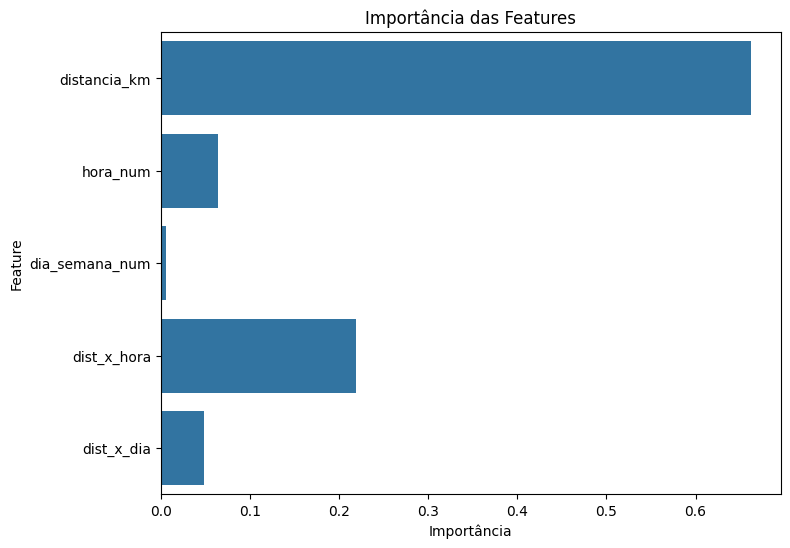

In [9]:
# Gráfico de importância das features
plt.figure(figsize=(8,6))
sns.barplot(x=modelo.feature_importances_, y=features_novas)
plt.title("Importância das Features")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()

 Modelo carregado!


/tmp/ipython-input-3390580344.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist_x_hora'] = X['distancia_km'] * X['hora_num']
/tmp/ipython-input-3390580344.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dist_x_dia'] = X['distancia_km'] * X['dia_semana_num']



🔹 LIMIAR DINÂMICO:
   Percentil: 60º
   Valor: 3.61%

 Classificação das corridas:
   Vantajosas: 40000 (40.0%)
   Não vantajosas: 60000 (60.0%)


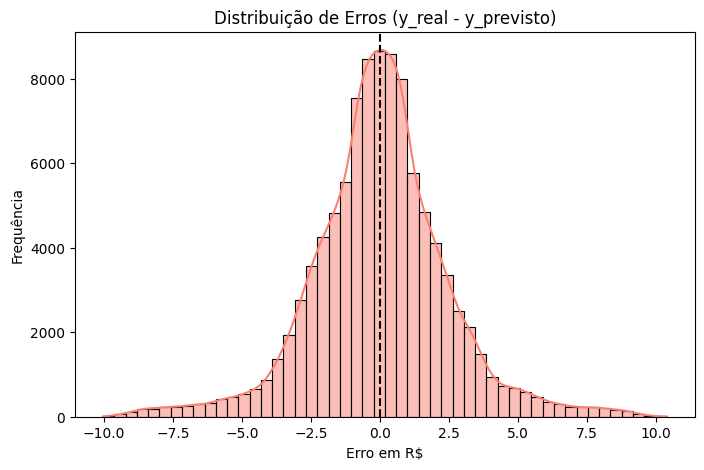

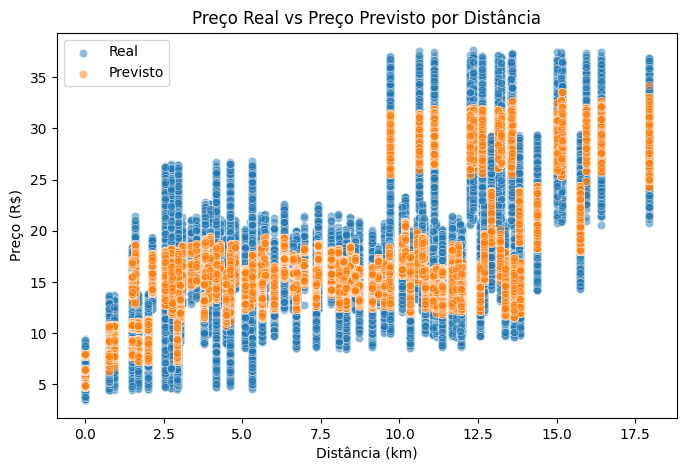

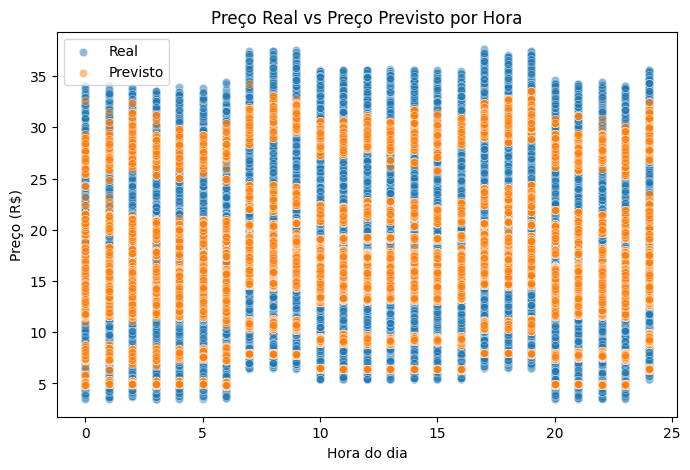

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


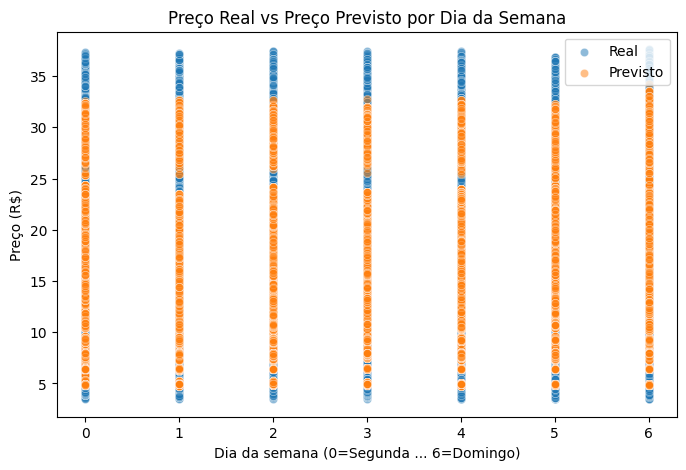

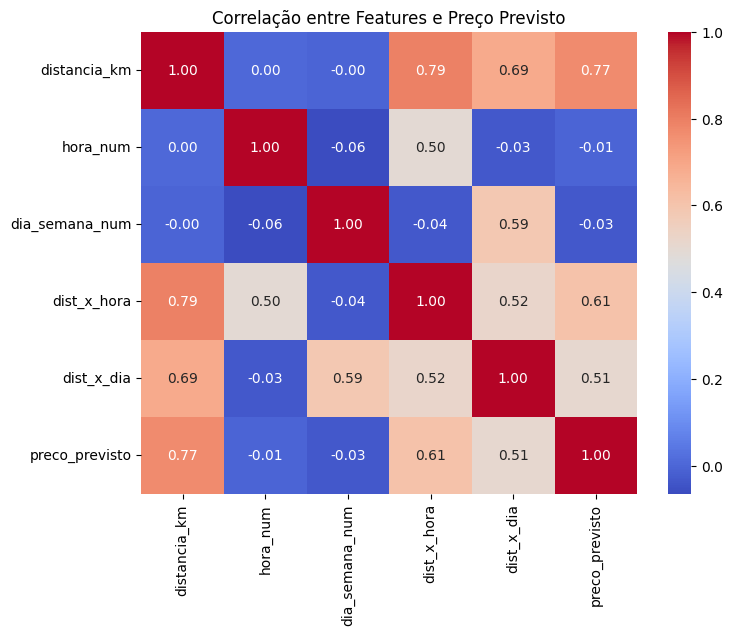

In [10]:
# CÉDULA 6 — AVALIAÇÃO E LIMIAR DINÂMICO (XGBOOST COM INTERAÇÕES

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib


#  Carregar modelo e scaler
modelo_loaded, scaler_loaded = joblib.load(MODEL_PATH)
print(" Modelo carregado!")

#  Garantir features de interação
if 'dist_x_hora' not in X.columns:
    X['dist_x_hora'] = X['distancia_km'] * X['hora_num']
if 'dist_x_dia' not in X.columns:
    X['dist_x_dia'] = X['distancia_km'] * X['dia_semana_num']


#  Escalar dataset completo

X_scaled = scaler_loaded.transform(X)
df['preco_previsto'] = modelo_loaded.predict(X_scaled)

# Diferença percentual e limiar dinâmico
epsilon = 1e-6
df['diferenca_pct'] = (df['preco'] - df['preco_previsto']) / (df['preco_previsto'] + epsilon)
df['diferenca_pct'] = df['diferenca_pct'].clip(-1, 3)

limiar_percentil = 60
limiar_dinamico = np.percentile(df['diferenca_pct'], limiar_percentil)

print(f"\n🔹 LIMIAR DINÂMICO:")
print(f"   Percentil: {limiar_percentil}º")
print(f"   Valor: {limiar_dinamico:.2%}")

#  Classificação das corridas
df['vantajoso'] = df['diferenca_pct'] > limiar_dinamico
total_vantajosas = df['vantajoso'].sum()
pct_vantajosas = (total_vantajosas / len(df)) * 100

print(f"\n Classificação das corridas:")
print(f"   Vantajosas: {total_vantajosas} ({pct_vantajosas:.1f}%)")
print(f"   Não vantajosas: {len(df) - total_vantajosas} ({100-pct_vantajosas:.1f}%)")

#  Gráficos de análise

#  Distribuição de erros
erros = df['preco'] - df['preco_previsto']
plt.figure(figsize=(8,5))
sns.histplot(erros, bins=50, kde=True, color='salmon')
plt.axvline(0, color='black', linestyle='--')
plt.title("Distribuição de Erros (y_real - y_previsto)")
plt.xlabel("Erro em R$")
plt.ylabel("Frequência")
plt.show()

#  Preço previsto vs Distância
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['distancia_km'], y=df['preco'], label='Real', alpha=0.5)
sns.scatterplot(x=df['distancia_km'], y=df['preco_previsto'], label='Previsto', alpha=0.5)
plt.title("Preço Real vs Preço Previsto por Distância")
plt.xlabel("Distância (km)")
plt.ylabel("Preço (R$)")
plt.legend()
plt.show()

#  Preço previsto vs Hora do dia
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['hora_num'], y=df['preco'], label='Real', alpha=0.5)
sns.scatterplot(x=df['hora_num'], y=df['preco_previsto'], label='Previsto', alpha=0.5)
plt.title("Preço Real vs Preço Previsto por Hora")
plt.xlabel("Hora do dia")
plt.ylabel("Preço (R$)")
plt.legend()
plt.show()

#  Preço previsto vs Dia da semana
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['dia_semana_num'], y=df['preco'], label='Real', alpha=0.5)
sns.scatterplot(x=df['dia_semana_num'], y=df['preco_previsto'], label='Previsto', alpha=0.5)
plt.title("Preço Real vs Preço Previsto por Dia da Semana")
plt.xlabel("Dia da semana (0=Segunda ... 6=Domingo)")
plt.ylabel("Preço (R$)")
plt.legend()
plt.show()

# Correlação entre features e preço previsto
df_corr = X.copy()
df_corr['preco_previsto'] = df['preco_previsto']
plt.figure(figsize=(8,6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre Features e Preço Previsto")
plt.show()

In [11]:
# CÉDULA 7 — GOOGLE MAPS API

import os
from datetime import datetime

# Instalar googlemaps
try:
    import googlemaps
except ImportError:
    os.system("pip install -q googlemaps")
    import googlemaps

# Configurar API Key
GMAPS_KEY = os.environ.get("GMAPS_KEY", )

if GMAPS_KEY is None or GMAPS_KEY == "keyg":
    print(" Google Maps API não configurada! Sistema não fará consultas reais.")
    gmaps = None
else:
    try:
        gmaps = googlemaps.Client(key=GMAPS_KEY)
        print(" Google Maps API configurada!")
    except Exception as e:
        print(f" Erro: {e}. Google Maps não disponível.")
        gmaps = None

# Função principal do Google Maps
def get_route_info(origem, destino):
    """Consulta Google Maps. Retorna distância e duração."""
    if gmaps is None:
        raise RuntimeError("Google Maps não configurado")

    try:
        now = datetime.now()
        result = gmaps.directions(
            origem + ", Fortaleza, CE, Brasil",
            destino + ", Fortaleza, CE, Brasil",
            mode="driving",
            departure_time=now,
            traffic_model="best_guess"
        )

        if not result:
            raise ValueError("Nenhuma rota encontrada")

        leg = result[0]["legs"][0]
        distance_km = leg["distance"]["value"] / 1000.0
        duration_min = leg["duration"]["value"] / 60.0

        if "duration_in_traffic" in leg:
            duration_traffic_min = leg["duration_in_traffic"]["value"] / 60.0
        else:
            duration_traffic_min = duration_min * 1.2

        return round(distance_km, 2), round(duration_min, 1), round(duration_traffic_min, 1)

    except Exception as e:
        raise RuntimeError(f"Erro no Google Maps: {e}")

 Google Maps API não configurada! Sistema não fará consultas reais.


In [12]:
# CÉDULA 8 — FUNÇÃO DE PREDIÇÃO DE CORRIDAS

import joblib
from datetime import datetime

def predict_trip(origem, destino, dia=None, hora=None, preco_real=None):
    """
    Prediz se uma corrida é vantajosa.

    Retorna: dict com análise completa
    """
    # Carregar modelo
    try:
        modelo_pred, scaler_pred = joblib.load(MODEL_PATH)
    except FileNotFoundError:
        return {"erro": "Modelo não encontrado!", "decisao": "ERRO"}

    # Valores padrão
    now = datetime.now()
    if dia is None:
        dia = now.weekday()
    if hora is None:
        hora = now.hour + now.minute / 60.0

    # Obter informações de rota
    dist_km, dur_min, dur_trafego = get_route_info(origem, destino)

    # Criar entrada para o modelo
    X_novo = pd.DataFrame(
        [[dist_km, hora, dia]],
        columns=['distancia_km', 'hora_num', 'dia_semana_num']
    )

    # 🔹 Features de interação (mesmo que no treino)
    X_novo['dist_x_hora'] = X_novo['distancia_km'] * X_novo['hora_num']
    X_novo['dist_x_dia']  = X_novo['distancia_km'] * X_novo['dia_semana_num']

    # Escalar
    X_novo_scaled = scaler_pred.transform(X_novo)

    # Prever preço
    preco_previsto = modelo_pred.predict(X_novo_scaled)[0]

    # Calcular tarifa e custos
    if preco_real is not None:
        tarifa = preco_real
    else:
        tarifa = 5.0 + (2.5 * dist_km) + (0.5 * dur_min / 5)

    custo = (0.8 * dist_km) + (0.5 * dur_min / 5)
    lucro = tarifa - custo

    # Classificar
    diferenca_pct = (tarifa - preco_previsto) / (preco_previsto + 1e-6)
    vantajosa = diferenca_pct > limiar_dinamico

    # Definir decisão
    if diferenca_pct > limiar_dinamico:
        decisao = " ACEITAR"
        explicacao = (
            f"Corrida VANTAJOSA! Tarifa R$ {tarifa:.2f} está "
            f"{diferenca_pct*100:.1f}% acima do esperado. "
            f"Lucro: R$ {lucro:.2f}."
        )
    elif diferenca_pct > (limiar_dinamico * 0.5):
        decisao = " DEPENDE"
        explicacao = (
            f"Corrida INCERTA. Tarifa R$ {tarifa:.2f} próxima do esperado. "
            f"Lucro: R$ {lucro:.2f}."
        )
    else:
        decisao = " RECUSAR"
        explicacao = (
            f"Corrida DESVANTAJOSA. Tarifa R$ {tarifa:.2f} está "
            f"{abs(diferenca_pct)*100:.1f}% ABAIXO do esperado. "
            f"Lucro baixo: R$ {lucro:.2f}."
        )

    return {
        "origem": origem,
        "destino": destino,
        "distancia_km": round(dist_km, 2),
        "duracao_min": round(dur_min, 1),
        "duracao_trafego_min": round(dur_trafego, 1),
        "tarifa": round(tarifa, 2),
        "custo": round(custo, 2),
        "lucro": round(lucro, 2),
        "preco_previsto": round(preco_previsto, 2),
        "diferenca_pct": round(diferenca_pct, 4),
        "decisao": decisao,
        "explicacao": explicacao
    }

# Teste rápido
print("\n Testando função de predição corrigida:")
resultado_teste = predict_trip("Meireles", "Aldeota")
print(f"   {resultado_teste['decisao']}")
print(f"   {resultado_teste['explicacao']}")



 Testando função de predição corrigida:


RuntimeError: Google Maps não configurado

In [13]:
# CÉDULA 9 — PROCESSAMENTO DE LINGUAGEM NATURAL

try:
    import spacy
    print(" spacy já instalado")
except ImportError:
    print(" Instalando spacy...")
    os.system("pip install -q spacy")
    import spacy

# Carregar modelo
try:
    nlp = spacy.load("pt_core_news_sm")
    print(" Modelo pt_core_news_sm carregado")
except OSError:
    print(" Baixando modelo...")
    os.system("python -m spacy download pt_core_news_sm")
    nlp = spacy.load("pt_core_news_sm")
    print(" Modelo carregado!")

# Função fallback com regex
def parse_trip_request(texto):
    """Extrai origem e destino usando regex."""
    texto = texto.lower().strip()
    padroes = [
        r'(?:quero\s+ir\s+)?(?:de|do|da)\s+(.+?)\s+(?:para|até|ate|a)\s+(.+)',
        r'(?:de|do|da)\s+(.+?)\s+(?:para|até|ate|a)\s+(.+)',
        r'(.+?)\s+(?:para|até|ate|->)\s+(.+)',
        r'(.+?)\s*->\s*(.+)'
    ]

    for padrao in padroes:
        match = re.search(padrao, texto)
        if match:
            origem = match.group(1).strip().title()
            destino = match.group(2).strip().title()
            return origem, destino

    raise ValueError("Formato não reconhecido. Use: 'de [ORIGEM] para [DESTINO]'")

# Função principal com NLP
def parse_trip_request_nlp(texto):
    """Extrai origem e destino usando NLP."""
    doc = nlp(texto)
    locais = [ent.text.strip().title() for ent in doc.ents if ent.label_ == "LOC"]

    if len(locais) >= 2:
        return locais[0], locais[1]

    return parse_trip_request(texto)

# Teste
print("\n Testando NLP:")
exemplos = [
    "quero ir de Meireles ate Aldeota",
    "Messejana p Mucuripe"
]
for ex in exemplos:
    try:
        o, d = parse_trip_request_nlp(ex)
        print(f"    '{ex}' → {o} para {d}")
    except Exception as e:
        print(f"   Erro: {e}")

 spacy já instalado
 Baixando modelo...
 Modelo carregado!

 Testando NLP:
    'quero ir de Meireles ate Aldeota' → Meireles para Aldeota
    'Messejana p Mucuripe' → Messejana para Mucuripe


In [14]:
# 9.1 - LOGIN NO HUGGING FACE

from huggingface_hub import login
print(" token de acesso do Hugging Face (hf_...) ")


login(new_session=False)

 token de acesso do Hugging Face (hf_...) 


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
# CÉLULA 10 - LLM (GEMMA 3-4B-IT)

try:
    print("Instalando bibliotecas para LLM Open-Source...")
    !pip install -q transformers accelerate bitsandbytes torch

    from transformers import AutoModelForCausalLM, AutoTokenizer
    import torch

    # Modelo Gemma 3-4B-IT
    model_name = "google/gemma-3-4b-it"

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Carregamento do Modelo com Otimização
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype=torch.bfloat16,
        load_in_4bit=True
    )

    llm_disponivel = True
    print(f" Modelo {model_name} ")

except Exception as e:
    print(f" Erro ao carregar o LLM")
    print(f"Erro: {e}")
    llm_disponivel = False

Instalando bibliotecas para LLM Open-Source...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.9 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

 Modelo google/gemma-3-4b-it 


In [16]:
# CÉLULA 11 — FUNÇÕES DE INTERAÇÃO E LLM

from datetime import datetime
import joblib
import re
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer # Garantir imports

# 1. FUNÇÃO LLM (chamar_llm_explicacao)

def chamar_llm_explicacao(origem, destino, tarifa, custo, lucro, diferenca_pct, decisao):



    # 1.1. Contexto Completo
    dados_corrida = f"""
    - Origem: {origem}
    - Destino: {destino}
    - Tarifa Recebida: R$ {tarifa:.2f}
    - Custo Operacional: R$ {custo:.2f}
    - Lucro Estimado: R$ {lucro:.2f}
    - Diferença vs Preço Esperado: {diferenca_pct*100:.1f}%
    - Decisão do Modelo ML: {decisao}
    """

    # 1.2. Mensagens do Chat
    messages = [
        {
            "role": "system",
            "content": "Você é um assistente de motorista de aplicativo que explica de forma concisa (máximo 50 palavras) o motivo de aceitar ou recusar uma corrida, focando apenas na lógica financeira da diferença de preço e no lucro."
        },
        {
            "role": "user",
            "content": f"Analise os dados abaixo e explique de forma concisa (máximo 50 palavras) a decisão '{decisao}':\n{dados_corrida}"
        }
    ]

    # 2. GERAÇÃO COM CHAT TEMPLATE
    global llm_disponivel, model, tokenizer # Declarar variáveis globais
    if llm_disponivel:
        try:
            # Aplica o template de chat do Gemma
            inputs = tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,
                tokenize=True,
                return_dict=True,
                return_tensors="pt",
            ).to(model.device)

            # Geração com limite de tokens
            output = model.generate(
                **inputs,
                max_new_tokens=100,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

            response_text = tokenizer.decode(output[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)

            return response_text.strip().replace('\n', ' ')

        except Exception as e:
            return f"(Erro LLM Crítico) Não foi possível gerar explicação. Lucro R$ {lucro:.2f}."
    else:
        return f"LLM Indisponível. Lucro R$ {lucro:.2f}."


# 2. FUNÇÃO PRINCIPAL DE INTERAÇÃO (motorista_interativo_texto)


def motorista_interativo_texto(texto_motorista, tarifa_app=None):
    """
    Processa o texto do motorista, consulta Maps, prevê com XGBoost e explica com LLM.
    """
    global gmaps, limiar_dinamico, MODEL_PATH, get_route_info # Variáveis de outras células

    try:
        # 1. Processamento de Linguagem Natural (NLP)
        origem, destino = parse_trip_request_nlp(texto_motorista)

        # 2. Carregar modelo e scaler
        modelo, scaler = joblib.load(MODEL_PATH)

        # 3. Dia e hora atuais
        now = datetime.now()
        dia = now.weekday()
        hora = now.hour + now.minute / 60.0

        # 4. Obter distância e duração via Google Maps (Cd 7)
        if gmaps is None:
            return {"erro": "Google Maps API não configurada ou com erro."}
        try:
            dist_km, dur_min, dur_trafego = get_route_info(origem, destino)
        except Exception as e:
            return {"erro": f"Erro ao obter rota no Maps: {e}"}

        X_novo = pd.DataFrame(
            [[dist_km, hora, dia]],
            columns=['distancia_km', 'hora_num', 'dia_semana_num']
        )
        # Features de interação
        X_novo['dist_x_hora'] = X_novo['distancia_km'] * X_novo['hora_num']
        X_novo['dist_x_dia'] = X_novo['distancia_km'] * X_novo['dia_semana_num']

        # Escalar e Prever preço esperado
        X_novo_scaled = scaler.transform(X_novo)
        preco_previsto = modelo.predict(X_novo_scaled)[0]

        # 6. Determinar tarifa, custo e lucro
        tarifa = tarifa_app
        custo = (0.8 * dist_km) + (0.5 * dur_min / 5)
        lucro = tarifa - custo

        # 7. Classificação da corrida (Decisão ML)
        diferenca_pct = (tarifa - preco_previsto) / (preco_previsto + 1e-6)

        if diferenca_pct > limiar_dinamico:
            decisao = "ACEITAR"
        elif diferenca_pct > (limiar_dinamico * 0.5):
            decisao = "DEPENDE"
        else:
            decisao = "RECUSAR"

        # 8. Chamar LLM para explicação curta
        explicacao = chamar_llm_explicacao(
            origem, destino, tarifa, custo, lucro, diferenca_pct, decisao
        )

        # 9. Retornar resultados completos
        return {
            "origem": origem,
            "destino": destino,
            "distancia_km": round(dist_km, 2),
            "duracao_min": round(dur_min, 1),
            "duracao_trafego_min": round(dur_trafego, 1),
            "tarifa": round(tarifa, 2),
            "custo": round(custo, 2),
            "lucro": round(lucro, 2),
            "preco_previsto": round(preco_previsto, 2),
            "diferenca_pct": round(diferenca_pct, 4),
            "decisao": decisao,
            "explicacao": explicacao
        }

    except Exception as e:
        return {"erro": f"Erro fatal durante a interação: {e}"}


# 3. INTERFACE DE INPUT PARA O USUÁRIO


print("\n INTERAÇÃO COM O MOTORISTA (XGBOOST + GEMMA LLM)")
print("--------------------------------------------------")

# 1. Pede o texto da corrida
texto_motorista = input("➡️ Digite o pedido da corrida (Ex: de Aldeota para Meireles): ")

# 2. Pede a tarifa oferecida
tarifa_recebida_str = input("➡️ Digite a tarifa oferecida pelo App (Ex: 15.00): ")

print("\nAnalisando a rota e a oferta...")

try:
    # converter a tarifa para float
    tarifa_recebida = float(tarifa_recebida_str)

    # Chama a função principal de processamento
    resultado_corrida = motorista_interativo_texto(texto_motorista, tarifa_recebida)

    # 3. Imprime o resultado formatado
    if "erro" in resultado_corrida:
        print(f"\n ERRO NA CONSULTA: {resultado_corrida['erro']}")
    else:
        print("\n=== DECISÃO DO SISTEMA ===")
        print(f"Bairros: {resultado_corrida['origem']} → {resultado_corrida['destino']}")
        print(f"Distância/Duração: {resultado_corrida['distancia_km']} km / {resultado_corrida['duracao_min']} min")
        print(f"Tarifa Recebida: R$ {resultado_corrida['tarifa']:.2f} | Preço Esperado: R$ {resultado_corrida['preco_previsto']:.2f}")
        print(f"Lucro Estimado: R$ {resultado_corrida['lucro']:.2f}")
        print(f"Diferença vs Esperado: {resultado_corrida['diferenca_pct']*100:.1f}%")
        print(f" DECISÃO: **{resultado_corrida['decisao']}**")
        print(f" Explicação LLM: {resultado_corrida['explicacao']}")

except ValueError:
    print("\n ERRO: Por favor, digite a tarifa em formato numérico válido (ex: 15.00).")



 INTERAÇÃO COM O MOTORISTA (XGBOOST + GEMMA LLM)
--------------------------------------------------


KeyboardInterrupt: Interrupted by user

In [18]:
# CÉLULA 12 — CORRIDAS SIMULADAS SEM API UTILIZANDO GPS COM CORDENADAS E LLM PARA EXPLICAR DECISÃO DO ML


import time
import random
from datetime import datetime
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt, atan2
import joblib


# Funções que usam 'coord_dict' e 'bairros_disponiveis' da Célula 3
def pegar_gps_fortaleza():
    """Retorna um bairro aleatório de Fortaleza."""
    global bairros_disponiveis # Assegura que a lista global da Célula 3 é usada
    return random.choice(bairros_disponiveis)

def gerar_corrida_simulada_offline():
    """Gera uma corrida com dados simulados."""
    origem = pegar_gps_fortaleza()
    destino = pegar_gps_fortaleza()
    while origem == destino:
        destino = pegar_gps_fortaleza()

    # Simular dados
    dia = random.randint(0, 6) # 0=Segunda, 6=Domingo
    hora = random.randint(0, 23)
    dist_km = calcular_distancia(origem, destino) # Usa a função da Célula 3

    # Simular duração (baseada na distância + ruído)
    dur_min = (dist_km * 3) + random.uniform(2, 8)

    # Simular tarifa (baseada em uma regra simples + ruído)
    tarifa_base = 5.0 + (2.5 * dist_km) + (0.5 * dur_min / 5)
    tarifa = round(tarifa_base * random.uniform(0.8, 1.3), 2)

    return origem, destino, dia, hora, tarifa, dist_km, dur_min

def predict_trip_offline(origem, destino, dia, hora, tarifa, dist_km, dur_min):
    """Prediz se uma corrida é vantajosa, sem Google Maps."""
    try:
        # Carregar modelo e scaler (da Célula 5)
        modelo_pred, scaler_pred = joblib.load(MODEL_PATH)
    except FileNotFoundError:
        return {"erro": "Modelo não encontrado!", "decisao": "ERRO", "explicacao": "(Erro LLM) Modelo ML indisponível"}

    # Criar entrada para o modelo
    X_novo = pd.DataFrame(
        [[dist_km, hora, dia]],
        columns=['distancia_km', 'hora_num', 'dia_semana_num']
    )

    # Features de interação (mesmo que no treino)
    X_novo['dist_x_hora'] = X_novo['distancia_km'] * X_novo['hora_num']
    X_novo['dist_x_dia'] = X_novo['distancia_km'] * X_novo['dia_semana_num']

    # Escalar
    X_novo_scaled = scaler_pred.transform(X_novo)

    # Prever preço
    preco_previsto = modelo_pred.predict(X_novo_scaled)[0]

    # Calcular custo e lucro
    custo = (0.8 * dist_km) + (0.5 * dur_min / 5)
    lucro = tarifa - custo

    # Classificar
    global limiar_dinamico # Usa o limiar da Célula 6
    diferenca_pct = (tarifa - preco_previsto) / (preco_previsto + 1e-6)

    if diferenca_pct > limiar_dinamico:
        decisao = "ACEITAR"
    elif diferenca_pct > (limiar_dinamico * 0.5):
        decisao = "DEPENDE"
    else:
        decisao = "RECUSAR"

    return {
        "origem": origem,
        "destino": destino,
        "distancia_km": round(dist_km, 2),
        "duracao_min": round(dur_min, 1),
        "tarifa": round(tarifa, 2),
        "custo": round(custo, 2),
        "lucro": round(lucro, 2),
        "preco_previsto": round(preco_previsto, 2),
        "diferenca_pct": round(diferenca_pct, 4),
        "decisao": decisao,
        "explicacao": f"Padrão: {decisao} - Lucro estimado R$ {lucro:.2f}"
    }


# Loop para gerar corridas simuladas

# ATIVAR O LLM
try:
    # Tenta usar a variável global 'model' (do Gemma) configurada na Célula 10
    _ = model
    llm_disponivel = True
    # Corrigindo a mensagem para refletir o modelo real que estamos usando
    print(" LLM (Gemma 3-4B-IT) Ativado para Explicações!")
except NameError:
    llm_disponivel = False
    print(" LLM (Gemma 3-4B-IT) Indisponível. Usando Explicação Padrão.")


for i in range(5):  # gera 5 corridas de exemplo
    # ESTAS FUNÇÕES AGORA ESTÃO DEFINIDAS ACIMA
    origem, destino, dia, hora, tarifa, dist_km, dur_min = gerar_corrida_simulada_offline()
    resultado = predict_trip_offline(origem, destino, dia, hora, tarifa, dist_km, dur_min)

    # Simulação de explicação LLM
    if llm_disponivel:
        try:
            # Chama a função de LLM
            explicacao_llm = chamar_llm_explicacao(
                origem, destino,
                resultado['tarifa'],
                resultado['custo'],
                resultado['lucro'],
                resultado['diferenca_pct'],
                resultado['decisao']
            )
        except Exception as e:

            explicacao_llm = f"ERRO LLM CRÍTICO ({type(e).__name__}): {e} | Decisão ML: {resultado['decisao']}"
    else:
        explicacao_llm = resultado['explicacao']


    print(f"\n=== CORRIDA {i+1} ===")
    print(f"Bairros: {origem} → {destino}")
    print(f"Distância/Duração: {resultado['distancia_km']} km / {resultado['duracao_min']} min")
    print(f"Tarifa Recebida: R$ {resultado['tarifa']:.2f} | Preço Esperado: R$ {resultado['preco_previsto']:.2f}")
    print(f"Lucro Estimado: R$ {resultado['lucro']:.2f}")
    print(f"Diferença vs Esperado: {resultado['diferenca_pct']*100:.1f}%")
    print(f" DECISÃO: **{resultado['decisao']}**")
    print(f" Explicação : {explicacao_llm}")

    time.sleep(2)

 LLM (Gemma 3-4B-IT) Ativado para Explicações!

=== CORRIDA 1 ===
Bairros: Siqueira → Genibau
Distância/Duração: 2.53 km / 14.8 min
Tarifa Recebida: R$ 14.66 | Preço Esperado: R$ 15.56
Lucro Estimado: R$ 11.16
Diferença vs Esperado: -5.8%
 DECISÃO: **RECUSAR**
 Explicação : RECUSAR: A corrida de Siqueira para Genibau tem lucro baixo e uma grande diferença negativa em relação ao preço esperado. O custo operacional de R$3,50 reduz o lucro estimado de R$11,16, resultando em um retorno financeiramente inviável para a corrida.

=== CORRIDA 2 ===
Bairros: Guararapes → Conjunto Palmeiras
Distância/Duração: 10.18 km / 37.8 min
Tarifa Recebida: R$ 42.50 | Preço Esperado: R$ 19.16
Lucro Estimado: R$ 30.58
Diferença vs Esperado: 121.8%
 DECISÃO: **ACEITAR**
 Explicação : **ACEITAR:**  A corrida Guararapes-Conjunto Palmeiras oferece um lucro excelente. A tarifa recebida é significativamente superior ao custo operacional, gerando um lucro de R$ 30,58. A diferença de 121,8% indica uma oportunidade d